In [30]:
import numpy as np
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:

# Load the training dataset
train_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\train.csv',on_bad_lines='skip')
# Print the first 5 rows of the dataset
train_df.head()


C:\Users\o.gezerli\AppData\Local\Temp\ipykernel_5776\2661988154.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\train.csv',on_bad_lines='skip')


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.78252,N,435.0


In [4]:
test_df = pd.read_csv(r'C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\data\test.csv')


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930061 entries, 0 to 930060
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  930061 non-null  object 
 1   vendor_id           930061 non-null  int64  
 2   pickup_datetime     930061 non-null  object 
 3   dropoff_datetime    930061 non-null  object 
 4   passenger_count     930061 non-null  int64  
 5   pickup_longitude    930061 non-null  float64
 6   pickup_latitude     930061 non-null  float64
 7   dropoff_longitude   930061 non-null  float64
 8   dropoff_latitude    930061 non-null  object 
 9   store_and_fwd_flag  930060 non-null  object 
 10  trip_duration       930060 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 78.1+ MB


In [6]:
train_df.describe()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,trip_duration
count,930061.000000,930061.000000,930061.000000,930061.000000,930061.000000,930060.000000
mean,1.508762,1.605882,-73.975191,40.743919,-73.976606,905.496964
std,0.499923,1.263716,0.046321,0.035696,0.027408,1640.152951
min,1.000000,0.000000,-77.896019,37.777771,-77.896019,1.000000
25%,1.000000,1.000000,-73.998734,40.724667,-73.991180,413.000000
50%,2.000000,1.000000,-73.986832,40.745327,-73.978989,802.000000
75%,2.000000,2.000000,-73.969620,40.769341,-73.965775,1156.000000
max,2.000000,6.000000,-72.809669,51.881084,-72.711395,86390.000000


In [7]:
train_df = train_df.dropna()

<Axes: ylabel='trip_duration'>

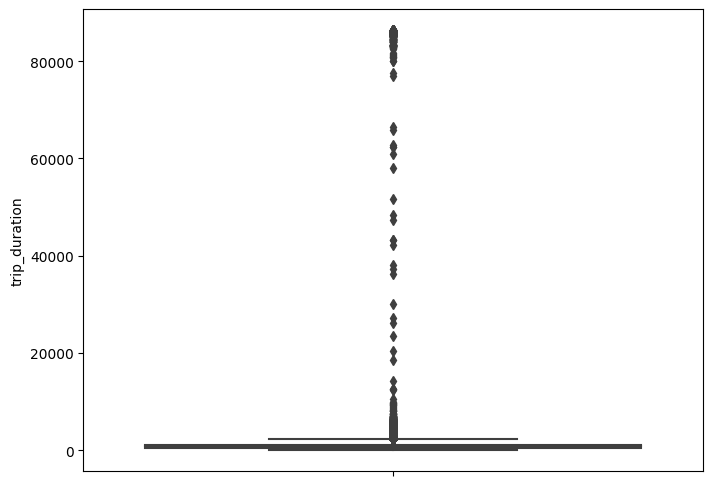

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(y=train_df['trip_duration'])

In [9]:
train_df.trip_duration.quantile(0.25)

413.0

In [10]:
train_df.trip_duration.quantile(0.75)

1156.0

In [11]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
train_df['dropoff_datetime'] = pd.to_datetime(train_df['dropoff_datetime'])
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
train_df['month'] = train_df['pickup_datetime'].dt.month

In [12]:
train_df = train_df.drop(['pickup_datetime', 'dropoff_datetime'], axis = 1)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930060 entries, 0 to 930059
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  930060 non-null  object 
 1   vendor_id           930060 non-null  int64  
 2   passenger_count     930060 non-null  int64  
 3   pickup_longitude    930060 non-null  float64
 4   pickup_latitude     930060 non-null  float64
 5   dropoff_longitude   930060 non-null  float64
 6   dropoff_latitude    930060 non-null  object 
 7   store_and_fwd_flag  930060 non-null  object 
 8   trip_duration       930060 non-null  float64
 9   hour                930060 non-null  int32  
 10  dayofweek           930060 non-null  int32  
 11  month               930060 non-null  int32  
dtypes: float64(4), int32(3), int64(2), object(3)
memory usage: 81.6+ MB


In [14]:
train_df['dropoff_latitude'] = train_df['dropoff_latitude'].astype('float64')
train_df['store_and_fwd_flag'] = train_df['store_and_fwd_flag'].astype('bool')

In [15]:
train_df['vendor_id'] = train_df['vendor_id'].astype('category')
train_df = pd.get_dummies(train_df, columns=['store_and_fwd_flag'], prefix='flag', drop_first=True)

In [16]:
train_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,dayofweek,month
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455.0,17,0,3
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663.0,0,6,6
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0,11,1,1
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,429.0,19,2,4
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,435.0,13,5,3


In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 930060 entries, 0 to 930059
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 930060 non-null  object  
 1   vendor_id          930060 non-null  category
 2   passenger_count    930060 non-null  int64   
 3   pickup_longitude   930060 non-null  float64 
 4   pickup_latitude    930060 non-null  float64 
 5   dropoff_longitude  930060 non-null  float64 
 6   dropoff_latitude   930060 non-null  float64 
 7   trip_duration      930060 non-null  float64 
 8   hour               930060 non-null  int32   
 9   dayofweek          930060 non-null  int32   
 10  month              930060 non-null  int32   
dtypes: category(1), float64(5), int32(3), int64(1), object(1)
memory usage: 68.3+ MB


In [18]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [19]:
train_df['distance'] = train_df.apply(lambda row: haversine_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

In [21]:
train_df['speed'] = (train_df['distance'] / train_df['trip_duration']) * 60 * 60

In [22]:
train_df['is_weekend'] = np.where((train_df['dayofweek'] == 5) | (train_df['dayofweek'] == 6), 1, 0)
train_df['is_weekend'] = train_df['is_weekend'].astype('bool')
train_df = train_df.drop('dayofweek', axis = 1)

In [25]:
kmeans = KMeans(n_clusters = 100, random_state = 42)
pickup_clusters = kmeans.fit_predict(train_df[['pickup_latitude', 'pickup_longitude']])
train_df['pickup_cluster'] = pickup_clusters

C:\Users\o.gezerli\OneDrive - FlixBus GmbH (B2E B2B) - Prod\Desktop\code_projects\nyc_taxi_trip_duration_python\nyc_taxi_trip_duration\.env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
train_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,month,distance,speed,is_weekend,pickup_cluster
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455.0,17,3,1.498521,11.856428,False,61
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663.0,0,6,1.805507,9.803659,True,83
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124.0,11,1,6.385098,10.822201,False,32
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,429.0,19,4,1.485498,12.465721,False,48
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,435.0,13,3,1.188588,9.836594,True,10


In [29]:
X = train_df.drop(['id', 'trip_duration'], axis = 1)
y = train_df['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
params = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'silent': 1,
    'random_state': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical = True)

watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [33]:
num_boost_round = 100

model = xgb.train(
    params,
    dtrain,
    num_boost_round,
    evals=watchlist,
    early_stopping_rounds=10
)

[17:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:1325.68180	eval-rmse:1336.96036
[1]	train-rmse:1033.57694	eval-rmse:1061.19936
[2]	train-rmse:741.20905	eval-rmse:775.68213
[3]	train-rmse:538.98607	eval-rmse:583.99114
[4]	train-rmse:400.79277	eval-rmse:452.14377
[5]	train-rmse:305.50554	eval-rmse:370.63575
[6]	train-rmse:285.17126	eval-rmse:357.32335
[7]	train-rmse:230.19904	eval-rmse:313.78584
[8]	train-rmse:194.69803	eval-rmse:288.24847
[9]	train-rmse:158.99516	eval-rmse:269.35941
[10]	train-rmse:143.22635	eval-rmse:260.67369
[11]	train-rmse:138.32866	eval-rmse:258.35393
[12]	train-rmse:136.63776	eval-rmse:257.87349
[13]	train-rmse:122.38059	eval-rmse:258.32075
[14]	train-rmse:113.57875	eval-rmse:259.97382
[15]	train-rmse:104.53964	eval-rmse:254.53830
[16]	train-rmse:102.32530	eval-rmse:254.32673
[17]	train-rmse:95.26957	eva

In [43]:
y_train_pred = model.predict(dtrain)

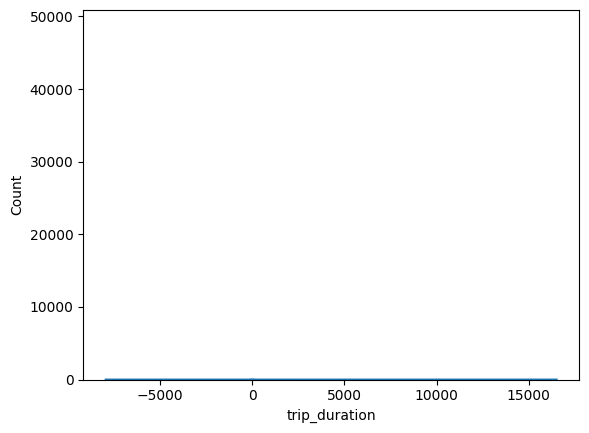

In [45]:
residuals = y_train - y_train_pred
sns.histplot(residuals, kde=True)
plt.show()